## Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

metadata = pd.read_csv('metadata.csv')
metadata.columns = ['book_id', 'title', 'publication_year', 'link']


In [2]:
metadata.head()

,book_id,title,publication_year,link
0,10006,La Fiammetta by Giovanni Boccaccio,1907,http://www.gutenberg.org/ebooks/10006
1,1001,Divine Comedy Inferno by Dante Alighieri,1882,http://www.gutenberg.org/ebooks/1001
2,10021,Tenterhooks by Ada Leverson,1912,http://www.gutenberg.org/ebooks/10021
3,10024,Beneath the Banner by F. J. Cross,1895,http://www.gutenberg.org/ebooks/10024
4,10028,Spalding's Official Baseball Guide 1913 Edited...,1913,http://www.gutenberg.org/ebooks/10028


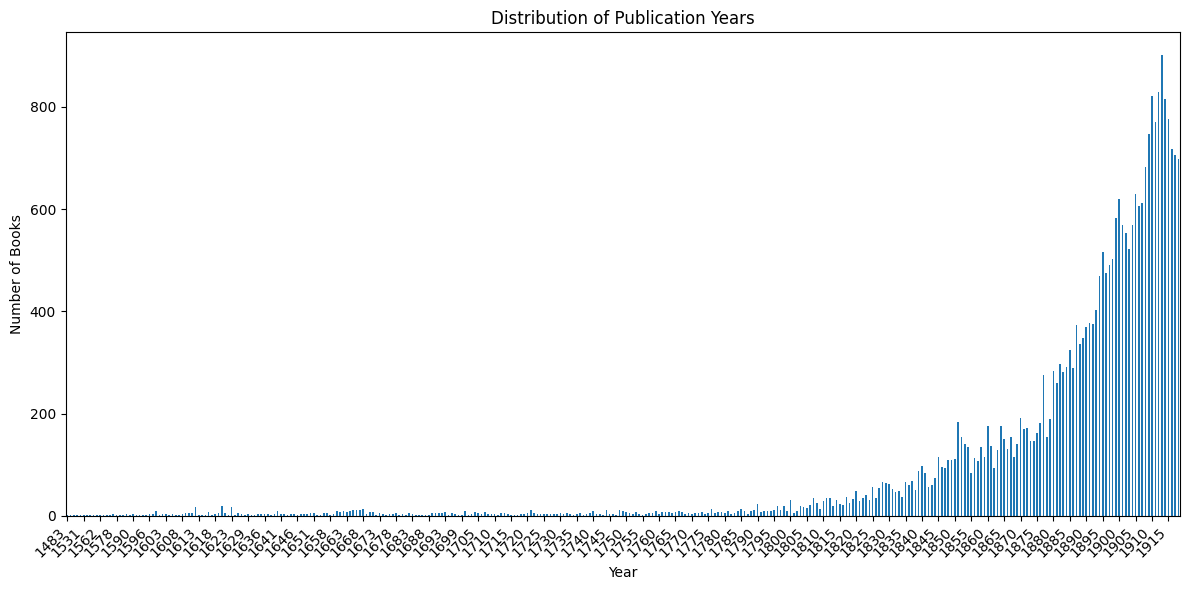

In [3]:
import matplotlib.pyplot as plt

# Plot distribution
plt.figure(figsize=(12, 6))
year_counts = metadata.iloc[:, 2].value_counts().sort_index()
year_counts.plot(kind='bar')

plt.title('Distribution of Publication Years')
plt.xlabel('Year')
plt.ylabel('Number of Books')

# Rotate x-axis labels and show only every nth label (e.g., every 5th year)
tick_freq = 5
plt.xticks(
    ticks=range(0, len(year_counts), tick_freq),
    labels=year_counts.index[::tick_freq],
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()



In [4]:
year_counts_df = metadata.iloc[:, 2].value_counts().sort_index().reset_index()
year_counts_df.columns = ['Year', 'Count']
display(year_counts_df)

,Year,Count
0,1483,1
1,1485,1
2,1509,1
3,1520,1
4,1530,2
...,...,...
334,1914,815
335,1915,777
336,1916,717
337,1917,705


Data has massive skew left, need to try and get data into format with uniform distribution. Can try by getting sentence excerpts from texts.

In [5]:
# Create mapping of book_id to publication_year
id_to_year = dict(zip(metadata['book_id'], metadata['publication_year']))

In [6]:
import os
import random
import re
from collections import defaultdict
import nltk
from nltk.tokenize import sent_tokenize
from multiprocessing import Pool, cpu_count

In [7]:
ERA_RANGES_1 = [(1483, 1525), (1525, 1575), (1575, 1625), (1625, 1675),
              (1675, 1725), (1725, 1775), (1775, 1825), (1825, 1875), (1875, 1919)]
ERA_RANGES_2 = [(1483, 1600), (1600, 1700), (1700, 1800), (1800, 1900), (1900, 2000)]

def get_era(year):
    for i, (start, end) in enumerate(ERA_RANGES_2):
        if start <= year <= end:
            return f"{start}-{end}"
    return None

def split_into_sentences_reg(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return [s.strip() for s in sentences if len(s.strip()) > 0]

def split_into_sentences_tokenize(text):
    return [s.strip() for s in sent_tokenize(text) if len(s.strip()) > 0]

def extract_random_excerpts(sentences, num_excerpts=5, min_len=3, max_len=5):
    excerpts = []
    if len(sentences) < min_len:
        return excerpts
    for _ in range(num_excerpts):
        start = random.randint(0, max(0, len(sentences) - min_len))
        end = start + random.randint(min_len, min(max_len, len(sentences) - start))
        excerpt = ' '.join(sentences[start:end])
        excerpts.append(excerpt)
    return excerpts

def process_text_files(text_dir, id_to_year, excerpts_per_file=5):
    era_buckets = defaultdict(list)
    text_dir = os.path.expanduser(text_dir)

    for file_name in os.listdir(text_dir):
        if file_name.endswith('.txt'):
            book_id = int(file_name.split('.')[0])
            if book_id in id_to_year:
                year = id_to_year[book_id]
                era = get_era(year)
                if era:
                    with open(os.path.join(text_dir, file_name), 'r', encoding='utf-8') as f:
                        text_content = f.read()
                        sentences = split_into_sentences_tokenize(text_content)
                        excerpts = extract_random_excerpts(sentences, num_excerpts=excerpts_per_file)
                        for excerpt in excerpts:
                            era_buckets[era].append({
                                'text': excerpt,
                                'label': era,
                                'book_id': book_id 
                            })
    return era_buckets

def sample_uniform_dataset(era_buckets, samples_per_era):
    dataset = []
    for era, excerpts in era_buckets.items():
        if len(excerpts) >= samples_per_era:
            dataset.extend(random.sample(excerpts, samples_per_era))
        else:
            print(f"Warning: Not enough excerpts in era {era}, only {len(excerpts)} available")
            dataset.extend(excerpts)  # include all available if below threshold
    random.shuffle(dataset)
    return dataset

# allows resampling of documents from era with few enteries
def sample_uniform_dataset_with_resampling(era_buckets, samples_per_era, id_to_year, text_dir, excerpts_per_file=5, max_resample_attempts=5):
    dataset = []
    text_dir = os.path.expanduser(text_dir)

    for era, excerpts in era_buckets.items():
        if len(excerpts) >= samples_per_era:
            dataset.extend(random.sample(excerpts, samples_per_era))
        else:
            print(f"Warning: Not enough excerpts in era {era}, only {len(excerpts)} available — resampling...")
            dataset.extend(excerpts)
            needed = samples_per_era - len(excerpts)

            # Get all book_ids from this era
            book_ids_in_era = [bid for bid, year in id_to_year.items() if get_era(year) == era]
            attempts = 0

            while needed > 0 and attempts < max_resample_attempts:
                attempts += 1
                random.shuffle(book_ids_in_era)  # shuffle to avoid always starting with the same ones
                for book_id in book_ids_in_era:
                    file_path = os.path.join(text_dir, f"{book_id}.txt")
                    if not os.path.isfile(file_path):
                        continue
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            text = f.read()
                            sentences = split_into_sentences_tokenize(text)
                            new_excerpts = extract_random_excerpts(sentences, num_excerpts=excerpts_per_file)
                            for excerpt in new_excerpts:
                                dataset.append({'text': excerpt, 'label': era, 'book_id': book_id})
                                needed -= 1
                                if needed == 0:
                                    break
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
                if needed > 0:
                    print(f"Still need {needed} more excerpts for era {era} after attempt {attempts}")
    
    random.shuffle(dataset)
    return dataset


 Use multiprocessing to parallelize file processing

In [8]:
from multiprocessing import Pool, cpu_count

def process_single_file(args):
    file_path, book_id, year = args
    era = get_era(year)
    if not era:
        return []

    with open(file_path, 'r', encoding='utf-8') as f:
        text_content = f.read()
        sentences = split_into_sentences_tokenize(text_content)
        excerpts = extract_random_excerpts(sentences, num_excerpts=5)
        return [{'text': excerpt, 'label': era, 'book_id': book_id} for excerpt in excerpts]

def process_multiple_text_files(text_dir, id_to_year, excerpts_per_file=5):
    text_dir = os.path.expanduser(text_dir)
    args_list = []
    
    for file_name in os.listdir(text_dir):
        if file_name.endswith('.txt'):
            book_id = int(file_name.split('.')[0])
            if book_id in id_to_year:
                year = id_to_year[book_id]
                file_path = os.path.join(text_dir, file_name)
                args_list.append((file_path, book_id, year))

    era_buckets = defaultdict(list)
    with Pool(cpu_count()) as pool:
        all_results = pool.map(process_single_file, args_list)

    for result in all_results:
        for item in result:
            era_buckets[item['label']].append(item)

    return era_buckets


I believe we are going to want 5,000–10,000 total samples, since this is standard for BERT/Transformer models. 80% training, 10% validation, 10% test set split

In [9]:
era_buckets = process_multiple_text_files('all_texts', id_to_year, excerpts_per_file=5)
#uniform_dataset = sample_uniform_dataset(era_buckets, samples_per_era=1000) 
uniform_dataset = sample_uniform_dataset_with_resampling(
    era_buckets,
    samples_per_era=1000,
    id_to_year=id_to_year,
    text_dir='all_texts',
    excerpts_per_file=5
)


Still need 540 more excerpts for era 1483-1600 after attempt 1
Still need 310 more excerpts for era 1483-1600 after attempt 2
Still need 80 more excerpts for era 1483-1600 after attempt 3


In [10]:
uniform_excerpts_df = pd.DataFrame(uniform_dataset, columns=['text', 'label', 'book_id'])
uniform_excerpts_df.head()

,text,label,book_id
0,"""Sir, I have rather made it my choice to trans...",1800-1900,13139
1,"""Some very remarkable discoveries\nmust have c...",1800-1900,31681
2,"Every missionary to the islands can tell of ""d...",1900-2000,10862
3,"As it\nwas, they so took him by surprise that ...",1600-1700,5913
4,I was a joke turned upside down. After they ha...,1900-2000,12609


In [16]:
uniform_excerpts_df.shape

(5150, 3)

In [18]:
indices_to_drop = uniform_excerpts_df[uniform_excerpts_df['label'] == '1483-1600'].tail(150).index
uniform_excerpts_df = uniform_excerpts_df.drop(indices_to_drop)
uniform_excerpts_df.shape

(5000, 3)

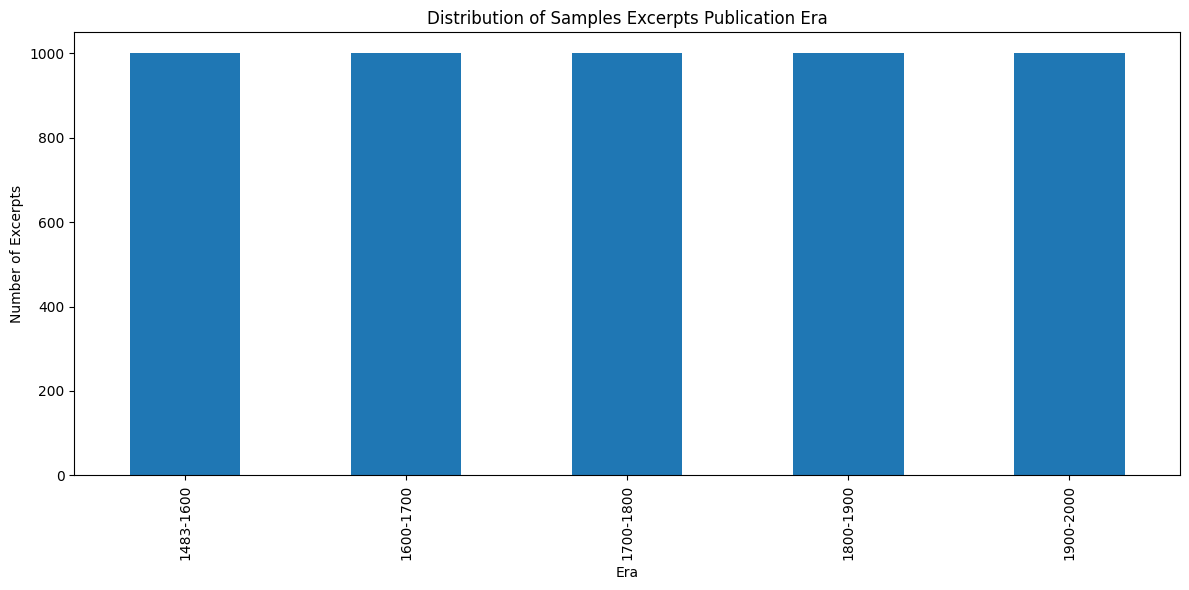

In [19]:
plt.figure(figsize=(12, 6))
year_counts = uniform_excerpts_df["label"].value_counts().sort_index()
year_counts.plot(kind='bar')

plt.title('Distribution of Samples Excerpts Publication Era')
plt.xlabel('Era')
plt.ylabel('Number of Excerpts')

plt.tight_layout()
plt.show()

In [ ]:
#uniform_excerpts_df.to_csv('uniform_excerpts_1.csv', index=False)